Validates that processed data meets YAMNet requirements:
- 16kHz sample rate
- 0.96s frame duration
- Proper amplitude normalization
- Class balance check

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import librosa.display

# Configuration
PROCESSED_ROOT = '../data/processed'
METADATA_PATH = os.path.join(PROCESSED_ROOT, 'processed_frames_metadata.csv')
TARGET_SR = 16000
EXPECTED_FRAME_SEC = 0.96
EXPECTED_SAMPLES = int(TARGET_SR * EXPECTED_FRAME_SEC)  # 15360 samples

In [10]:
# Load Metadata
print("\nLoading metadata...")
if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f"Metadata not found: {METADATA_PATH}")

df = pd.read_csv(METADATA_PATH)
print(f"Loaded {len(df)} frames")
print(f"Categories: {df['category'].unique().tolist()}")


Loading metadata...
Loaded 11906 frames
Categories: ['Alarm_Clock', 'Car_Horn', 'Glass_Breaking', 'Gunshot', 'Siren']


In [11]:
# Class Distribution & Balance
print("\nChecking class distribution...")
class_counts = df['category'].value_counts().sort_index()
print("\nFrames per category:")
for cat, count in class_counts.items():
    orig = len(df[(df['category'] == cat) & (df['aug_idx'] == 0)])
    aug = count - orig
    print(f"  {cat:20s}: {count:5d} ({orig:4d} original + {aug:4d} augmented)")

# Calculate balance metrics
max_count = class_counts.max()
min_count = class_counts.min()
balance_ratio = max_count / min_count
print(f"\nBalance ratio (max/min): {balance_ratio:.2f}")

if balance_ratio <= 1.5:
    print("EXCELLENT: Dataset is well balanced")
elif balance_ratio <= 2.0:
    print("GOOD: Dataset is reasonably balanced")
else:
    print("WARNING: Dataset is imbalanced - consider class weights")


Checking class distribution...

Frames per category:
  Alarm_Clock         :  2450 ( 490 original + 1960 augmented)
  Car_Horn            :  2325 ( 775 original + 1550 augmented)
  Glass_Breaking      :  2394 ( 399 original + 1995 augmented)
  Gunshot             :  2355 ( 785 original + 1570 augmented)
  Siren               :  2382 ( 794 original + 1588 augmented)

Balance ratio (max/min): 1.05
EXCELLENT: Dataset is well balanced


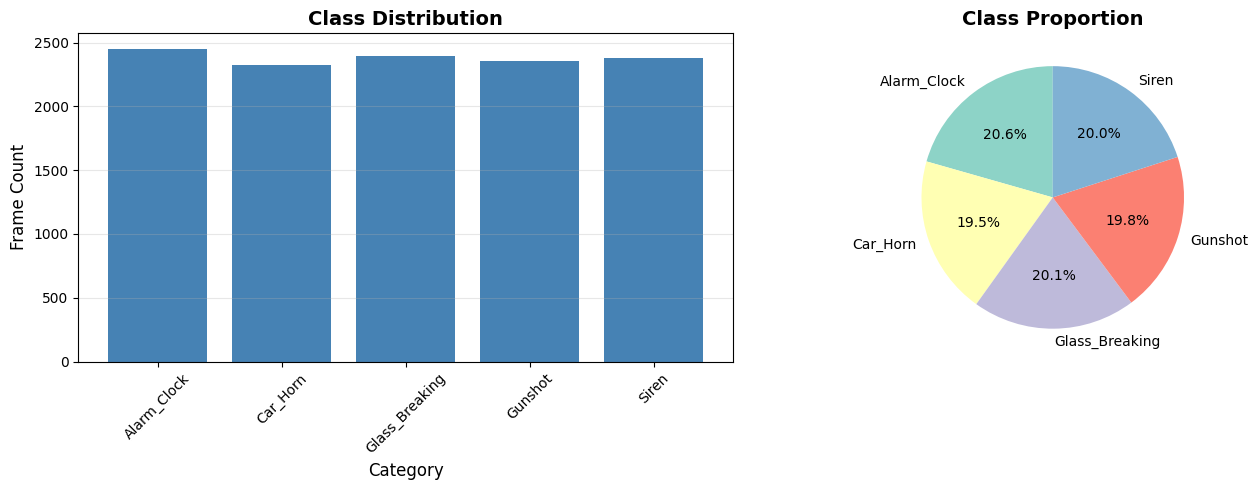

In [12]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(class_counts.index, class_counts.values, color='steelblue')
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Frame Count', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = plt.cm.Set3(range(len(class_counts)))
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# Sample Integrity Checks
print("\nValidating frame integrity...")

validation_results = {
    'valid_shape': 0,
    'invalid_shape': 0,
    'valid_range': 0,
    'clipped': 0,
    'silent': 0,
    'total_checked': 0
}

issues = []
sample_size = min(500, len(df))  # Check 500 random samples
sample_indices = np.random.choice(len(df), sample_size, replace=False)

print(f"Checking {sample_size} random frames...")

for idx in sample_indices:
    row = df.iloc[idx]
    frame_path = row['frame_path']
    
    if not os.path.exists(frame_path):
        issues.append(f"Missing file: {frame_path}")
        continue
    
    try:
        frame = np.load(frame_path)
        validation_results['total_checked'] += 1
        
        # Check shape
        if frame.shape == (EXPECTED_SAMPLES,):
            validation_results['valid_shape'] += 1
        else:
            validation_results['invalid_shape'] += 1
            issues.append(f"Invalid shape {frame.shape}: {frame_path}")
        
        # Check amplitude range
        if np.all(np.abs(frame) <= 1.0):
            validation_results['valid_range'] += 1
        else:
            issues.append(f"Out of range (max={np.max(np.abs(frame)):.2f}): {frame_path}")
        
        # Check for clipping
        if np.max(np.abs(frame)) >= 0.99:
            validation_results['clipped'] += 1
        
        # Check for silence
        rms = np.sqrt(np.mean(frame**2))
        if rms < 0.001:
            validation_results['silent'] += 1
            
    except Exception as e:
        issues.append(f"Error loading {frame_path}: {str(e)}")

# Print results
print(f"\nValidated {validation_results['total_checked']} frames")
print(f"  - Correct shape: {validation_results['valid_shape']}/{validation_results['total_checked']}")
print(f"  - Valid range: {validation_results['valid_range']}/{validation_results['total_checked']}")
print(f"  - Potentially clipped: {validation_results['clipped']}")
print(f"  - Low amplitude: {validation_results['silent']}")

if issues:
    print(f"\nFound {len(issues)} issues (showing first 10):")
    for issue in issues[:10]:
        print(f"  - {issue}")
else:
    print("\nNo issues found!")


Validating frame integrity...
Checking 500 random frames...

Validated 500 frames
  - Correct shape: 500/500
  - Valid range: 500/500
  - Potentially clipped: 0
  - Low amplitude: 0

No issues found!



Analyzing audio quality...


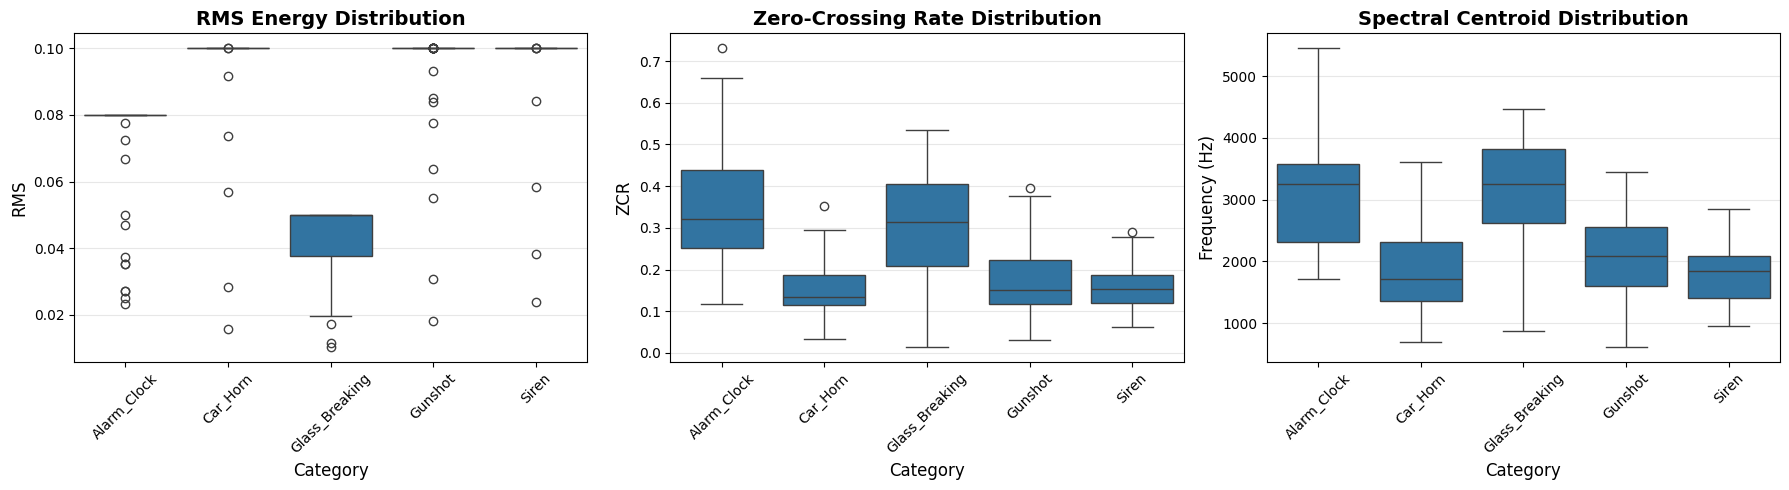


Quality statistics per category:
                   rms             zcr         spectral_centroid          
                  mean     std    mean     std              mean       std
category                                                                  
Alarm_Clock     0.0713  0.0181  0.3464  0.1494         3142.1200  877.8783
Car_Horn        0.0953  0.0167  0.1536  0.0702         1857.7352  626.4707
Glass_Breaking  0.0423  0.0118  0.3002  0.1524         3097.7079  870.3215
Gunshot         0.0942  0.0170  0.1725  0.0799         2105.9663  639.7683
Siren           0.0961  0.0149  0.1576  0.0529         1814.7017  468.2445


In [14]:
# Audio Quality Analysis
print("\nAnalyzing audio quality...")

# Sample 50 frames per category
quality_data = []
for category in df['category'].unique():
    cat_frames = df[df['category'] == category].sample(min(50, len(df[df['category'] == category])))
    
    for _, row in cat_frames.iterrows():
        try:
            frame = np.load(row['frame_path'])
            rms = np.sqrt(np.mean(frame**2))
            zcr = np.mean(librosa.feature.zero_crossing_rate(frame))
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=frame, sr=TARGET_SR))
            
            quality_data.append({
                'category': category,
                'rms': rms,
                'zcr': zcr,
                'spectral_centroid': spectral_centroid
            })
        except Exception as e:
            continue

quality_df = pd.DataFrame(quality_data)

# Visualize quality metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMS Energy
sns.boxplot(data=quality_df, x='category', y='rms', ax=axes[0])
axes[0].set_title('RMS Energy Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('RMS', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Zero-Crossing Rate
sns.boxplot(data=quality_df, x='category', y='zcr', ax=axes[1])
axes[1].set_title('Zero-Crossing Rate Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('ZCR', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Spectral Centroid
sns.boxplot(data=quality_df, x='category', y='spectral_centroid', ax=axes[2])
axes[2].set_title('Spectral Centroid Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Category', fontsize=12)
axes[2].set_ylabel('Frequency (Hz)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nQuality statistics per category:")
quality_stats = quality_df.groupby('category').agg({
    'rms': ['mean', 'std'],
    'zcr': ['mean', 'std'],
    'spectral_centroid': ['mean', 'std']
})
print(quality_stats.round(4))


Generating sample visualizations...


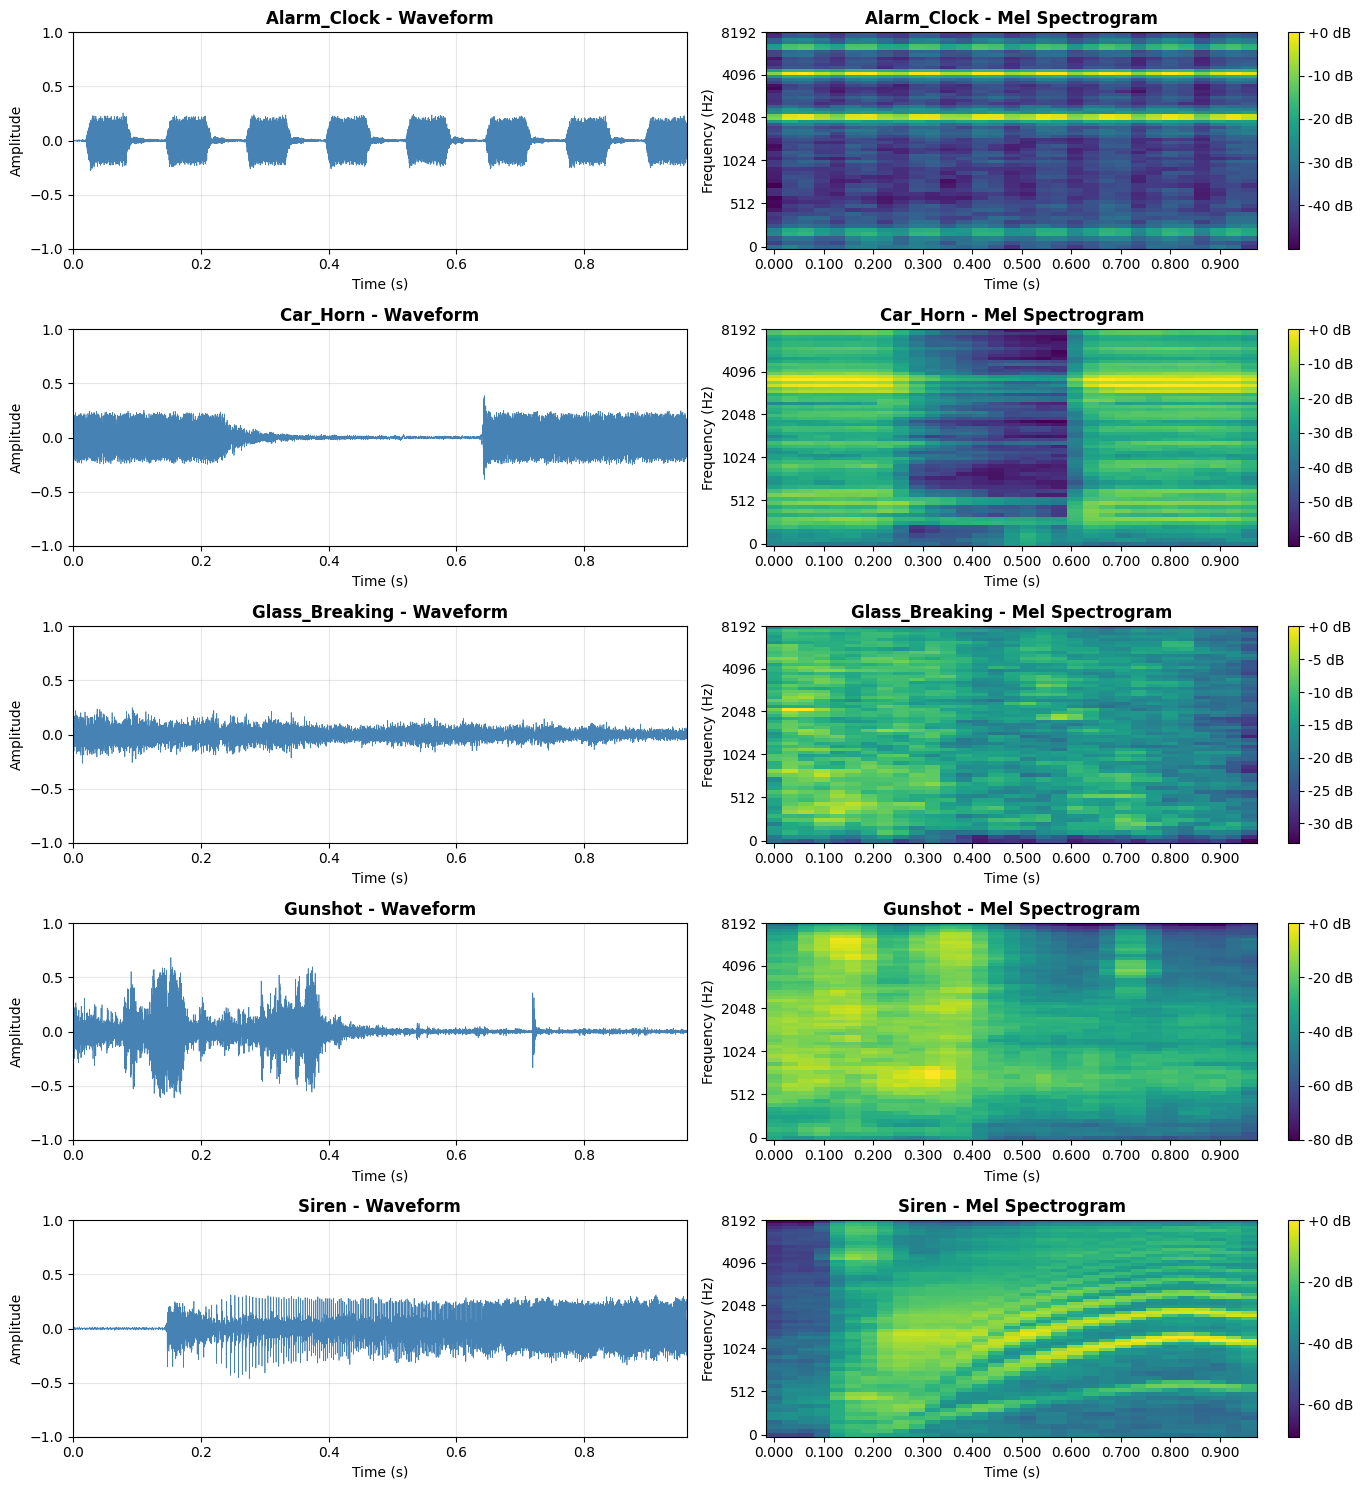

In [15]:
# Visualize Sample Waveforms & Spectrograms
print("\nGenerating sample visualizations...")

fig, axes = plt.subplots(len(df['category'].unique()), 2, figsize=(14, 3*len(df['category'].unique())))

for idx, category in enumerate(sorted(df['category'].unique())):
    # Get a random original frame (not augmented)
    cat_original = df[(df['category'] == category) & (df['aug_idx'] == 0)]
    if len(cat_original) == 0:
        continue
    
    sample_row = cat_original.sample(1).iloc[0]
    frame = np.load(sample_row['frame_path'])
    
    # Waveform
    time = np.linspace(0, len(frame) / TARGET_SR, len(frame))
    axes[idx, 0].plot(time, frame, linewidth=0.5, color='steelblue')
    axes[idx, 0].set_title(f'{category} - Waveform', fontweight='bold')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].set_xlim([0, EXPECTED_FRAME_SEC])
    axes[idx, 0].set_ylim([-1, 1])
    
    # Mel Spectrogram
    S = librosa.feature.melspectrogram(y=frame, sr=TARGET_SR, n_mels=64, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=TARGET_SR, 
                                    fmax=8000, ax=axes[idx, 1], cmap='viridis')
    axes[idx, 1].set_title(f'{category} - Mel Spectrogram', fontweight='bold')
    axes[idx, 1].set_xlabel('Time (s)')
    axes[idx, 1].set_ylabel('Frequency (Hz)')
    fig.colorbar(img, ax=axes[idx, 1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [16]:
# YAMNet Compatibility Summary
checks = {
    'Sample Rate': (TARGET_SR == 16000, f"{TARGET_SR} Hz"),
    'Frame Duration': (EXPECTED_FRAME_SEC == 0.96, f"{EXPECTED_FRAME_SEC} seconds"),
    'Frame Samples': (EXPECTED_SAMPLES == 15360, f"{EXPECTED_SAMPLES} samples"),
    'Class Balance': (balance_ratio <= 2.0, f"Ratio: {balance_ratio:.2f}"),
    'Valid Shapes': (validation_results['invalid_shape'] == 0, 
                     f"{validation_results['valid_shape']}/{validation_results['total_checked']}"),
    'Amplitude Range': (validation_results['valid_range'] == validation_results['total_checked'],
                       "[-1.0, 1.0]"),
    'Total Frames': (len(df) >= 5000, f"{len(df)} frames"),
}

all_passed = True
for check_name, (passed, info) in checks.items():
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"{status:8s} | {check_name:20s}: {info}")
    if not passed:
        all_passed = False

if all_passed:
    print("ALL CHECKS PASSED - Dataset is ready for YAMNet fine-tuning!")
else:
    print("SOME CHECKS FAILED - Review issues before proceeding")

✓ PASS   | Sample Rate         : 16000 Hz
✓ PASS   | Frame Duration      : 0.96 seconds
✓ PASS   | Frame Samples       : 15360 samples
✓ PASS   | Class Balance       : Ratio: 1.05
✓ PASS   | Valid Shapes        : 500/500
✓ PASS   | Amplitude Range     : [-1.0, 1.0]
✓ PASS   | Total Frames        : 11906 frames
ALL CHECKS PASSED - Dataset is ready for YAMNet fine-tuning!
